# Teaching machines to see better: Improving CNNs and making them confess

In this we will discuss various techniques to improve the CNN, such as, data augmentation, dropout. We will then train a model that is better suited for our data. Finally we will learn about transfer learning, and leverage it to download a pretrained model and train an offspring that's better than any model we've seen so far.


<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/thushv89/manning_tf2_in_action/blob/master/Ch07-Improving-CNNs-and-Explaining/7.3.Interpreting_CNNs_GradCAM.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
    </td>
</table>

## Importing necessary libraries <a class="anchor" id="import"></a>

In [1]:
import tensorflow as tf
import requests
import zipfile
import requests
import os
import time
import pandas as pd
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, AvgPool2D, Dense, Concatenate, Flatten, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
import numpy as np
from PIL import Image
import tensorflow.keras.backend as K
import pickle
from tensorflow.keras.models import load_model, Model

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except:
        print("Couldn't set memory_growth")
        pass
    
    
def fix_random_seed(seed):
    """ Setting the random seed of various libraries """
    try:
        np.random.seed(seed)
    except NameError:
        print("Warning: Numpy is not imported. Setting the seed for Numpy failed.")
    try:
        tf.random.set_seed(seed)
    except NameError:
        print("Warning: TensorFlow is not imported. Setting the seed for TensorFlow failed.")
    try:
        random.seed(seed)
    except NameError:
        print("Warning: random module is not imported. Setting the seed for random failed.")

# Fixing the random seed
random_seed=4321
fix_random_seed(random_seed)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.0


## Downloading data <a class="anchor" id="download-data"></a>

For this chapter, we're going to use the tiny-imagenet dataset (200 categories of objects). This is a simplified version of the bigger and harder imagenet dataset (1000 categories of objects).

## Some information about the  dataset

* There are 200 classes of data
* Each image is 64x64 RGB
* Training data has 500 images per each class
* Testing has 50 images per each class
* We separate 50 images from each class in the training set to create the validation set

```
n02124075 	Egyptian cat
n04067472 	reel
n04540053 	volleyball
n04099969 	rocking chair, rocker
n07749582 	lemon
```

In [2]:
import os
import requests
import zipfile

# Retrieve the data
if not os.path.exists(os.path.join('data','tiny-imagenet-200.zip')):
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    # Get the file from web
    r = requests.get(url)

    if not os.path.exists('data'):
        os.mkdir('data')
    
    # Write to a file
    with open(os.path.join('data','tiny-imagenet-200.zip'), 'wb') as f:
        f.write(r.content)
else:
    print("The zip file already exists.")
    
if not os.path.exists(os.path.join('data', 'tiny-imagenet-200')):
    with zipfile.ZipFile(os.path.join('data','tiny-imagenet-200.zip'), 'r') as zip_ref:
        zip_ref.extractall('data')
else:
    print("The extracted data already exists")

The zip file already exists.
The extracted data already exists


## Pretrained Inception Resnet v2 network (`tf.keras.applications`)

Here, we create a Sequential `tf.keras.models.Model` by wrapping,

* An Input layer having the size 224x224x3
* The downloaded Inception Resnet v2 model (without the top prediction layer and an average pooling layer on top)
* A dropout layer with 40% dropout rate
* A final prediction layer

In [3]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

K.clear_session()

def get_inception_resnet_v2_pretrained():
    model = Sequential([
        Input(shape=(224,224,3)),
        InceptionResNetV2(include_top=False, pooling='avg'),
        Dropout(0.4),
        Dense(200, activation='softmax')
    ])

    loss = tf.keras.losses.CategoricalCrossentropy()
    adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
    return model 

model = get_inception_resnet_v2_pretrained()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 200)               307400    
                                                                 
Total params: 54,644,136
Trainable params: 54,583,592
Non-trainable params: 60,544
_________________________________________________________________


## Making CNNs confess: Implementing GradCAM

This implementation produces the GradCAM visualizations. GradCAM is a technique introduced in [this paper](https://arxiv.org/pdf/1610.02391.pdf)

In [4]:
K.clear_session()

# Load the model from disk
try: 
    model = load_model(os.path.join('models','inception_resnet_v2.h5'))
except:
    # Sometimes loading the above model result in ValueError: Unknown layer: Functional
    print("Model loading failed. Trying a different method")
    model = get_inception_resnet_v2_pretrained()
    model.load_weights(os.path.join('models','inception_resnet_v2.h5'))

print("Model was successfully loaded")

def unwrap_model(model):
    inception = model.get_layer('inception_resnet_v2')
    inp = inception.input
    out = model.get_layer('dropout')(inception.output)
    out = model.get_layer('dense')(out)
    return Model(inp, out)   
    
unwrapped_model = unwrap_model(model)

unwrapped_model.summary()

Model was successfully loaded
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                             

                                                                                                  
 average_pooling2d (AveragePool  (None, None, None,   0          ['max_pooling2d_1[0][0]']        
 ing2D)                         192)                                                              
                                                                                                  
 conv2d_5 (Conv2D)              (None, None, None,   18432       ['max_pooling2d_1[0][0]']        
                                96)                                                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, None, None,   76800       ['activation_6[0][0]']           
                                64)                                                               
                                                                                                  
 conv2d_10

                                                                                                  
 batch_normalization_14 (BatchN  (None, None, None,   96         ['conv2d_14[0][0]']              
 ormalization)                  32)                                                               
                                                                                                  
 batch_normalization_17 (BatchN  (None, None, None,   192        ['conv2d_17[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 activation_12 (Activation)     (None, None, None,   0           ['batch_normalization_12[0][0]'] 
                                32)                                                               
                                                                                                  
 activatio

 block35_2_mixed (Concatenate)  (None, None, None,   0           ['activation_18[0][0]',          
                                128)                              'activation_20[0][0]',          
                                                                  'activation_23[0][0]']          
                                                                                                  
 block35_2_conv (Conv2D)        (None, None, None,   41280       ['block35_2_mixed[0][0]']        
                                320)                                                              
                                                                                                  
 block35_2 (Lambda)             (None, None, None,   0           ['block35_1_ac[0][0]',           
                                320)                              'block35_2_conv[0][0]']         
                                                                                                  
 block35_2

 batch_normalization_33 (BatchN  (None, None, None,   96         ['conv2d_33[0][0]']              
 ormalization)                  32)                                                               
                                                                                                  
 activation_33 (Activation)     (None, None, None,   0           ['batch_normalization_33[0][0]'] 
                                32)                                                               
                                                                                                  
 conv2d_31 (Conv2D)             (None, None, None,   10240       ['block35_3_ac[0][0]']           
                                32)                                                               
                                                                                                  
 conv2d_34 (Conv2D)             (None, None, None,   13824       ['activation_33[0][0]']          
          

 ormalization)                  48)                                                               
                                                                                                  
 activation_37 (Activation)     (None, None, None,   0           ['batch_normalization_37[0][0]'] 
                                32)                                                               
                                                                                                  
 activation_40 (Activation)     (None, None, None,   0           ['batch_normalization_40[0][0]'] 
                                48)                                                               
                                                                                                  
 conv2d_36 (Conv2D)             (None, None, None,   10240       ['block35_4_ac[0][0]']           
                                32)                                                               
          

                                                                                                  
 batch_normalization_42 (BatchN  (None, None, None,   96         ['conv2d_42[0][0]']              
 ormalization)                  32)                                                               
                                                                                                  
 batch_normalization_44 (BatchN  (None, None, None,   96         ['conv2d_44[0][0]']              
 ormalization)                  32)                                                               
                                                                                                  
 batch_normalization_47 (BatchN  (None, None, None,   192        ['conv2d_47[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 activatio

 activation_53 (Activation)     (None, None, None,   0           ['batch_normalization_53[0][0]'] 
                                64)                                                               
                                                                                                  
 block35_7_mixed (Concatenate)  (None, None, None,   0           ['activation_48[0][0]',          
                                128)                              'activation_50[0][0]',          
                                                                  'activation_53[0][0]']          
                                                                                                  
 block35_7_conv (Conv2D)        (None, None, None,   41280       ['block35_7_mixed[0][0]']        
                                320)                                                              
                                                                                                  
 block35_7

 conv2d_63 (Conv2D)             (None, None, None,   10240       ['block35_8_ac[0][0]']           
                                32)                                                               
                                                                                                  
 batch_normalization_63 (BatchN  (None, None, None,   96         ['conv2d_63[0][0]']              
 ormalization)                  32)                                                               
                                                                                                  
 activation_63 (Activation)     (None, None, None,   0           ['batch_normalization_63[0][0]'] 
                                32)                                                               
                                                                                                  
 conv2d_61 (Conv2D)             (None, None, None,   10240       ['block35_8_ac[0][0]']           
          

 ormalization)                  32)                                                               
                                                                                                  
 batch_normalization_70 (BatchN  (None, None, None,   144        ['conv2d_70[0][0]']              
 ormalization)                  48)                                                               
                                                                                                  
 activation_67 (Activation)     (None, None, None,   0           ['batch_normalization_67[0][0]'] 
                                32)                                                               
                                                                                                  
 activation_70 (Activation)     (None, None, None,   0           ['batch_normalization_70[0][0]'] 
                                48)                                                               
          

                                                                                                  
 activation_75 (Activation)     (None, None, None,   0           ['batch_normalization_75[0][0]'] 
                                384)                                                              
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, None, None,   0          ['block35_10_ac[0][0]']          
                                320)                                                              
                                                                                                  
 mixed_6a (Concatenate)         (None, None, None,   0           ['activation_72[0][0]',          
                                1088)                             'activation_75[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
          

 batch_normalization_80 (BatchN  (None, None, None,   576        ['conv2d_80[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 batch_normalization_83 (BatchN  (None, None, None,   576        ['conv2d_83[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 activation_80 (Activation)     (None, None, None,   0           ['batch_normalization_80[0][0]'] 
                                192)                                                              
                                                                                                  
 activation_83 (Activation)     (None, None, None,   0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 batch_normalization_90 (BatchN  (None, None, None,   480        ['conv2d_90[0][0]']              
 ormalization)                  160)                                                              
                                                                                                  
 activation_90 (Activation)     (None, None, None,   0           ['batch_normalization_90[0][0]'] 
                                160)                                                              
                                                                                                  
 conv2d_88 (Conv2D)             (None, None, None,   208896      ['block17_3_ac[0][0]']           
                                192)                                                              
                                                                                                  
 conv2d_91

                                1088)                                                             
                                                                                                  
 conv2d_97 (Conv2D)             (None, None, None,   139264      ['block17_5_ac[0][0]']           
                                128)                                                              
                                                                                                  
 batch_normalization_97 (BatchN  (None, None, None,   384        ['conv2d_97[0][0]']              
 ormalization)                  128)                                                              
                                                                                                  
 activation_97 (Activation)     (None, None, None,   0           ['batch_normalization_97[0][0]'] 
                                128)                                                              
          

 activation_103 (Activation)    (None, None, None,   0           ['batch_normalization_103[0][0]']
                                192)                                                              
                                                                                                  
 block17_7_mixed (Concatenate)  (None, None, None,   0           ['activation_100[0][0]',         
                                384)                              'activation_103[0][0]']         
                                                                                                  
 block17_7_conv (Conv2D)        (None, None, None,   418880      ['block17_7_mixed[0][0]']        
                                1088)                                                             
                                                                                                  
 block17_7 (Lambda)             (None, None, None,   0           ['block17_6_ac[0][0]',           
          

                                                                                                  
 conv2d_111 (Conv2D)            (None, None, None,   215040      ['activation_110[0][0]']         
                                192)                                                              
                                                                                                  
 batch_normalization_108 (Batch  (None, None, None,   576        ['conv2d_108[0][0]']             
 Normalization)                 192)                                                              
                                                                                                  
 batch_normalization_111 (Batch  (None, None, None,   576        ['conv2d_111[0][0]']             
 Normalization)                 192)                                                              
                                                                                                  
 activatio

                                128)                                                              
                                                                                                  
 conv2d_118 (Conv2D)            (None, None, None,   143360      ['activation_117[0][0]']         
                                160)                                                              
                                                                                                  
 batch_normalization_118 (Batch  (None, None, None,   480        ['conv2d_118[0][0]']             
 Normalization)                 160)                                                              
                                                                                                  
 activation_118 (Activation)    (None, None, None,   0           ['batch_normalization_118[0][0]']
                                160)                                                              
          

 block17_12 (Lambda)            (None, None, None,   0           ['block17_11_ac[0][0]',          
                                1088)                             'block17_12_conv[0][0]']        
                                                                                                  
 block17_12_ac (Activation)     (None, None, None,   0           ['block17_12[0][0]']             
                                1088)                                                             
                                                                                                  
 conv2d_125 (Conv2D)            (None, None, None,   139264      ['block17_12_ac[0][0]']          
                                128)                                                              
                                                                                                  
 batch_normalization_125 (Batch  (None, None, None,   384        ['conv2d_125[0][0]']             
 Normaliza

                                                                                                  
 activation_128 (Activation)    (None, None, None,   0           ['batch_normalization_128[0][0]']
                                192)                                                              
                                                                                                  
 activation_131 (Activation)    (None, None, None,   0           ['batch_normalization_131[0][0]']
                                192)                                                              
                                                                                                  
 block17_14_mixed (Concatenate)  (None, None, None,   0          ['activation_128[0][0]',         
                                384)                              'activation_131[0][0]']         
                                                                                                  
 block17_1

                                160)                                                              
                                                                                                  
 conv2d_136 (Conv2D)            (None, None, None,   208896      ['block17_15_ac[0][0]']          
                                192)                                                              
                                                                                                  
 conv2d_139 (Conv2D)            (None, None, None,   215040      ['activation_138[0][0]']         
                                192)                                                              
                                                                                                  
 batch_normalization_136 (Batch  (None, None, None,   576        ['conv2d_136[0][0]']             
 Normalization)                 192)                                                              
          

 batch_normalization_145 (Batch  (None, None, None,   384        ['conv2d_145[0][0]']             
 Normalization)                 128)                                                              
                                                                                                  
 activation_145 (Activation)    (None, None, None,   0           ['batch_normalization_145[0][0]']
                                128)                                                              
                                                                                                  
 conv2d_146 (Conv2D)            (None, None, None,   143360      ['activation_145[0][0]']         
                                160)                                                              
                                                                                                  
 batch_normalization_146 (Batch  (None, None, None,   480        ['conv2d_146[0][0]']             
 Normaliza

                                                                                                  
 block17_19_conv (Conv2D)       (None, None, None,   418880      ['block17_19_mixed[0][0]']       
                                1088)                                                             
                                                                                                  
 block17_19 (Lambda)            (None, None, None,   0           ['block17_18_ac[0][0]',          
                                1088)                             'block17_19_conv[0][0]']        
                                                                                                  
 block17_19_ac (Activation)     (None, None, None,   0           ['block17_19[0][0]']             
                                1088)                                                             
                                                                                                  
 conv2d_15

 Normalization)                 288)                                                              
                                                                                                  
 activation_156 (Activation)    (None, None, None,   0           ['batch_normalization_156[0][0]']
                                256)                                                              
                                                                                                  
 activation_158 (Activation)    (None, None, None,   0           ['batch_normalization_158[0][0]']
                                256)                                                              
                                                                                                  
 activation_161 (Activation)    (None, None, None,   0           ['batch_normalization_161[0][0]']
                                288)                                                              
          

                                448)                              'activation_166[0][0]']         
                                                                                                  
 block8_1_conv (Conv2D)         (None, None, None,   933920      ['block8_1_mixed[0][0]']         
                                2080)                                                             
                                                                                                  
 block8_1 (Lambda)              (None, None, None,   0           ['mixed_7a[0][0]',               
                                2080)                             'block8_1_conv[0][0]']          
                                                                                                  
 block8_1_ac (Activation)       (None, None, None,   0           ['block8_1[0][0]']               
                                2080)                                                             
          

 batch_normalization_171 (Batch  (None, None, None,   576        ['conv2d_171[0][0]']             
 Normalization)                 192)                                                              
                                                                                                  
 batch_normalization_174 (Batch  (None, None, None,   768        ['conv2d_174[0][0]']             
 Normalization)                 256)                                                              
                                                                                                  
 activation_171 (Activation)    (None, None, None,   0           ['batch_normalization_171[0][0]']
                                192)                                                              
                                                                                                  
 activation_174 (Activation)    (None, None, None,   0           ['batch_normalization_174[0][0]']
          

                                                                                                  
 batch_normalization_181 (Batch  (None, None, None,   672        ['conv2d_181[0][0]']             
 Normalization)                 224)                                                              
                                                                                                  
 activation_181 (Activation)    (None, None, None,   0           ['batch_normalization_181[0][0]']
                                224)                                                              
                                                                                                  
 conv2d_179 (Conv2D)            (None, None, None,   399360      ['block8_4_ac[0][0]']            
                                192)                                                              
                                                                                                  
 conv2d_18

                                2080)                                                             
                                                                                                  
 conv2d_188 (Conv2D)            (None, None, None,   399360      ['block8_6_ac[0][0]']            
                                192)                                                              
                                                                                                  
 batch_normalization_188 (Batch  (None, None, None,   576        ['conv2d_188[0][0]']             
 Normalization)                 192)                                                              
                                                                                                  
 activation_188 (Activation)    (None, None, None,   0           ['batch_normalization_188[0][0]']
                                192)                                                              
          

 activation_194 (Activation)    (None, None, None,   0           ['batch_normalization_194[0][0]']
                                256)                                                              
                                                                                                  
 block8_8_mixed (Concatenate)   (None, None, None,   0           ['activation_191[0][0]',         
                                448)                              'activation_194[0][0]']         
                                                                                                  
 block8_8_conv (Conv2D)         (None, None, None,   933920      ['block8_8_mixed[0][0]']         
                                2080)                                                             
                                                                                                  
 block8_8 (Lambda)              (None, None, None,   0           ['block8_7_ac[0][0]',            
          

                                                                                                  
 conv2d_202 (Conv2D)            (None, None, None,   172032      ['activation_201[0][0]']         
                                256)                                                              
                                                                                                  
 batch_normalization_199 (Batch  (None, None, None,   576        ['conv2d_199[0][0]']             
 Normalization)                 192)                                                              
                                                                                                  
 batch_normalization_202 (Batch  (None, None, None,   768        ['conv2d_202[0][0]']             
 Normalization)                 256)                                                              
                                                                                                  
 activatio

## Get the inputs, clases and labels

In this we define a function that will take in an image path, and return,

* The normalized transformed image accepted by the model
* The class (string)
* The label (int)

In [5]:
img_path = 'data/tiny-imagenet-200/val/images/val_434.JPEG'

val_df = pd.read_csv(os.path.join('data','tiny-imagenet-200', 'val', 'val_annotations.txt'),sep='\t', index_col=0, header=None)
with open(os.path.join('data','class_indices'),'rb') as f:
    class_indices = pickle.load(f)
words = pd.read_csv(os.path.join('data','tiny-imagenet-200', 'words.txt'), sep='\t', index_col=0, header=None)

def get_image_class_label(img_path, val_df, class_indices, words):
    """ Returns the normalized input, class (int) and the label name for a given image"""
    
    img = np.expand_dims(np.asarray(Image.open(img_path).resize((224,224)), dtype='float32'), axis=0)
    img /= 127.5
    img -= 1
    if img.ndim == 3:
        img = np.repeat(np.expand_dims(img, axis=-1), 3, axis=-1)
    _, img_name = os.path.split(img_path)
    wnid = val_df.loc[img_name,1]
    cls = class_indices[wnid]
    label = words.loc[wnid, 1]
    return img, cls, label

# Test the function with a test image
img, cls, label = get_image_class_label(img_path, val_df, class_indices, words)

## Compute the GradCAMs

Here for a set of given images, we compute the GradCAM heatmaps and store them in `grad_info` dictionary.

In [6]:
last_conv_layer = 'conv_7b' # This is the name of the last conv layer of the model

# There's an issue between inner model input and outer model input connection
# to fix that we feed the same input to both these inputs
grad_model = Model(
    inputs=unwrapped_model.inputs, 
    outputs=[unwrapped_model.get_layer(last_conv_layer).output, unwrapped_model.output]    
)

# Define a sample probe set to get GradCAM
image_fnames = [os.path.join('data','tiny-imagenet-200', 'val','images',f) \
                for f in ['val_9917.JPEG', 'val_9816.JPEG', 'val_9800.JPEG', 'val_9673.JPEG', 'val_9470.JPEG',\
                         'val_4.JPEG', 'val_127.JPEG', 'val_120.JPEG', 'val_256.JPEG', 'val_692.JPEG']]

grad_info = {}
for fname in image_fnames:
    # Get the normalized input, class(int) and label (string) for each image
    img, cls, label = get_image_class_label(fname, val_df, class_indices, words)
    
    # Monitoring the gradients in the GradientTape context
    with tf.GradientTape() as tape:
        conv_output, preds = grad_model(img)
        loss = preds[:, cls]
    
    # Get the gradient
    grads = tape.gradient(loss, conv_output)
    # Apply weights
    weights = tf.reduce_mean(grads, axis=(1, 2), keepdims=True)
    grads *= weights
    # Get the final heatmap
    grads = tf.reduce_sum(grads, axis=(0,3))
    grads = tf.nn.relu(grads)

    # normalize 
    grads /= tf.reduce_max(grads)
    grads = tf.cast(grads*255.0, 'uint8')
    
    grad_info[fname] = {'image': img, 'class': cls, 'label':label, 'gradcam': grads}

print("Collected {} GradCAMs".format(len(grad_info)))

Collected 10 GradCAMs


## Plot images and GradCAMs

Here we superimpose the GradCAM heatmap on the original image to provide a visualization of where the model focused on.

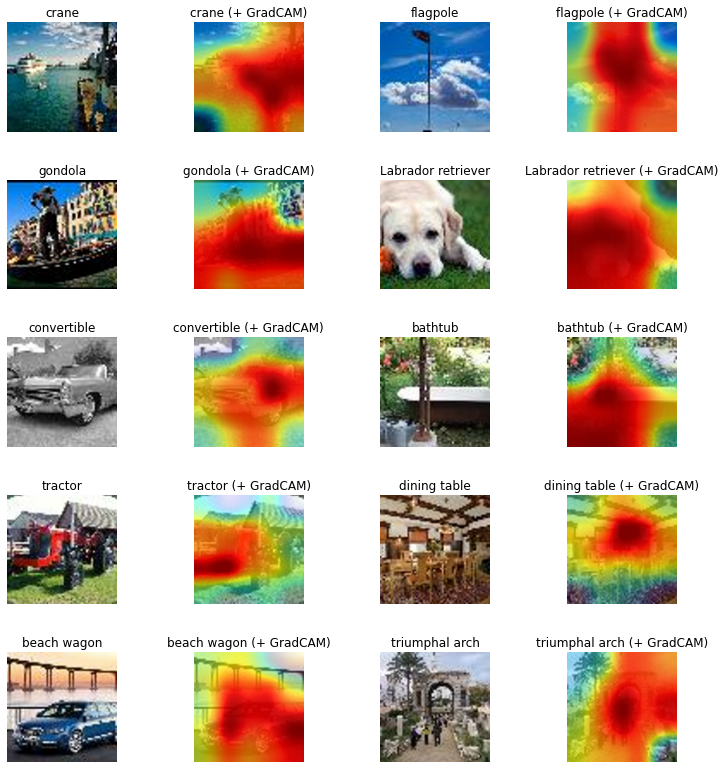

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Get colormap and modify its alpha value
ncolors = 256
cmap_name = 'jet'
color_array = plt.get_cmap(cmap_name)(range(ncolors))
# change alpha values
color_array[:,-1] = np.linspace(0.0,1.0,ncolors)
# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='{}_alpha'.format(cmap_name),colors=color_array)
# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

# Define figure
f, axes = plt.subplots(5, 4, figsize=(12,14))
plt.subplots_adjust(wspace=0.7)

for i, (k, v) in enumerate(grad_info.items()):
    
    cam = np.array(Image.fromarray(v["gradcam"].numpy()).resize((224,224)))
    orig_image = ((v["image"][0]+1)*127.5).astype('uint8')
    offset = 2*(i%2)    
    
    # Plotting each image
    axes[i//2][offset].imshow(orig_image)
    # Plotting w GradCAM
    axes[i//2][offset+1].imshow(orig_image)
    axes[i//2][offset+1].imshow(cam,cmap='{}_alpha'.format(cmap_name))
    
    # Set labels and turning off axes 
    axes[i//2][offset].set_title(v["label"].split(',')[0])
    axes[i//2][offset+1].set_title(v["label"].split(',')[0] + " (+ GradCAM)")    
    axes[i//2][offset].axis('off')
    axes[i//2][offset+1].axis('off')